# NY Housing Price - regression
## Part 2. Data Clearning + Feature Engineering
<br>

<a id = 'toc'></a>
**Table of Contents**

1. [Data cleaning](#dc)
    1. [Unwanted observations](#un) 
    2. [Structural errors](#struct)
        1. Typos
        2. Indicator
    3. [Outliers](#out)
    4. [Missing values](#miss)
        1. Categorial
        2. Numerical

2. [Feature engineering](#engine)
    1. [Domain knowledge](#domain)
        1. Premium for 2be + 2ba
        2. recession
    2. [Interaction features](#inter)
        1. property_age = tx_year-year_built (remove afterwards)
        2. school_score = median_school * num_school
        3. ba/be ratio
    3. [Group sparse terms](#sparse)
        1. roof
        2. exterier_walls
    4. [Encode dummy variable](#dummy)
        
3. [Save analytical base table](#train_df)


In [1]:
# import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../data/train.csv')
df.shape

(1506, 26)

In [3]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,257840,4,2,3796,1978,20473,Single-Family,Metal,Composition Shingle,1.0,0,0,0,0,1,0,0,0,49.0,91.0,83.0,593.0,181.0,8.0,1.0,1997
1,540000,4,3,2500,1971,10500,Single-Family,Brick,Composition Shingle,1.0,19,2,2,1,21,0,11,9,46.0,94.0,54.0,487.0,148.0,8.0,3.0,2013
2,300000,4,3,3480,1940,10890,Single-Family,Brick,Asphalt,1.0,32,2,5,8,36,8,25,35,45.0,81.0,88.0,1015.0,337.0,4.0,3.0,1993
3,650000,5,4,5809,2002,30056,Single-Family,NaN,Asphalt,1.0,4,0,1,0,4,0,5,8,37.0,64.0,55.0,727.0,187.0,7.0,3.0,2004
4,576145,4,3,3504,2004,4199,Single-Family,Siding (Alum/Vinyl),Composition Shingle,1.0,20,3,1,1,12,1,12,5,34.0,91.0,59.0,528.0,161.0,7.0,2.0,2005


In [4]:
target_col = 'tx_price'
cat_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
num_cols = df.dtypes[df.dtypes != 'object'].index.tolist()
print (target_col, cat_cols, num_cols)

tx_price ['property_type', 'exterior_walls', 'roof'] ['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size', 'basement', 'restaurants', 'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment', 'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad', 'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year']


<a id = 'dc'></a>
### 1. Data cleaning

<a id = 'un'></a>
#### 1. A. Unwanted observations

In [5]:
# check duplication
sum(df.duplicated(keep = False))

0

<a id = 'stuct'></a>
#### 1.B. Structural errors
##### 1.B.a. Typos

In [6]:
sorted(s.lower() for s in df.roof.value_counts().index.tolist())

['asbestos',
 'asphalt',
 'asphalt',
 'asphalt,shake-shingle',
 'built-up',
 'composition',
 'composition',
 'composition shingle',
 'gravel/rock',
 'metal',
 'other',
 'roll composition',
 'shake shingle',
 'shake-shingle',
 'slate',
 'wood shake/ shingles']

In [7]:
sorted(df.roof.value_counts().index.tolist())

['Asbestos',
 'Asphalt',
 'Built-up',
 'Composition',
 'Composition Shingle',
 'Gravel/Rock',
 'Metal',
 'Other',
 'Roll Composition',
 'Shake Shingle',
 'Slate',
 'Wood Shake/ Shingles',
 'asphalt',
 'asphalt,shake-shingle',
 'composition',
 'shake-shingle']

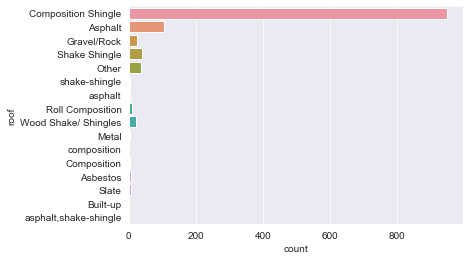

In [8]:
sns.countplot(y = 'roof', data= df)
plt.show()

In [9]:
roof_replace_dict = {'asphalt': 'Asphalt', 
               'composition': 'Composition',
               'shake-shingle': 'Shake Shingle'}

In [10]:
df.loc[:,'roof'] = df['roof'].replace(roof_replace_dict)

In [11]:
df.roof.value_counts()

Composition Shingle      951
Asphalt                  108
Shake Shingle             44
Other                     37
Gravel/Rock               24
Wood Shake/ Shingles      22
Roll Composition          10
Asbestos                   7
Slate                      6
Composition                6
Metal                      4
Built-up                   2
asphalt,shake-shingle      1
Name: roof, dtype: int64

In [12]:
df.exterior_walls.value_counts()

Brick                  547
Siding (Alum/Vinyl)    409
Metal                   93
Combination             84
Wood                    57
Brick veneer            41
Wood Siding             37
Stucco                  19
Other                    9
Concrete                 7
Concrete Block           7
Block                    6
Asbestos shingle         5
Rock, Stone              4
Masonry                  2
Wood Shingle             1
Name: exterior_walls, dtype: int64

In [13]:
sorted(s.lower() for s in df.exterior_walls.value_counts().index.tolist())

['asbestos shingle',
 'block',
 'brick',
 'brick veneer',
 'combination',
 'concrete',
 'concrete block',
 'masonry',
 'metal',
 'other',
 'rock, stone',
 'siding (alum/vinyl)',
 'stucco',
 'wood',
 'wood shingle',
 'wood siding']

##### 1.B.b. Indicator

In [14]:
df.basement.unique()

array([ 1., nan])

In [15]:
df.loc[:,'basement'] = df.basement.fillna(0)

In [16]:
df.basement.unique()

array([1., 0.])

<a id = 'out'></a>
#### 1.C. Outliers

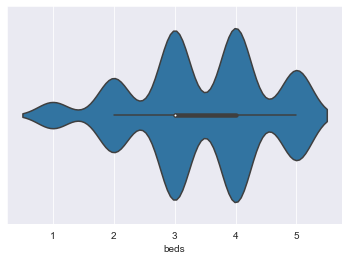

In [17]:
sns.violinplot(x = num_cols[1], data = df)
plt.show()

In [18]:
def plot_num_dist(num_cols):
    
    figsize = (18, 24)
    naxes = len(num_cols)
    
    if naxes%3 != 0:
        nrows = naxes//3 + 1
    else:
        nrows = naxes//3

    fig, axes = plt.subplots(nrows, 3, figsize=figsize)
    axes = axes.ravel()
    
    for i in range(len(num_cols)):
        sns.violinplot(df[num_cols[i]], ax = axes[i])
        axes[i].set_xlabel(num_cols[i], fontsize = 20)
    
    plt.tight_layout()

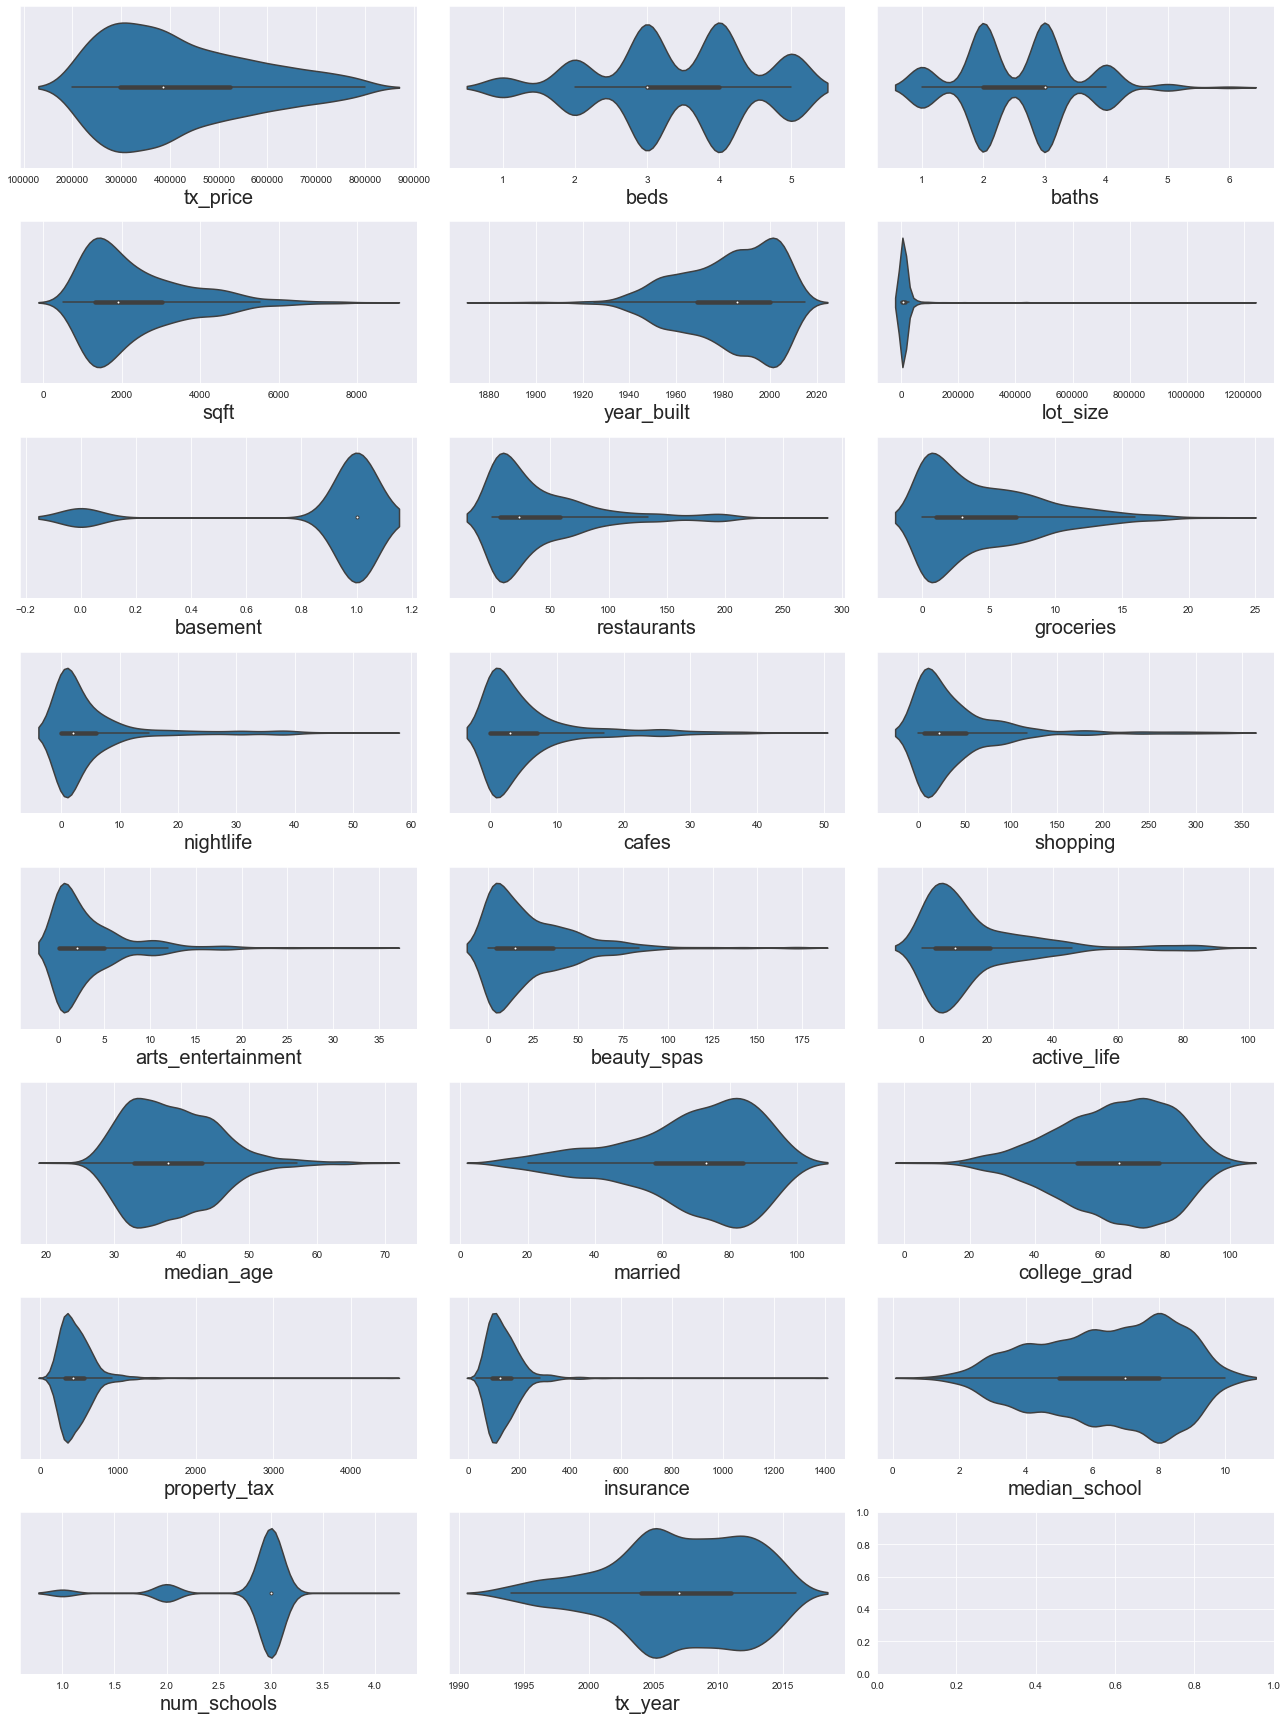

In [19]:
plot_num_dist(num_cols)

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tx_price,1506.0,419130.136786,151194.479127,200000.0,297000.00,386500.0,523000.00,800000.0
beds,1506.0,3.426295,1.074723,1.0,3.00,3.0,4.00,5.0
baths,1506.0,2.580345,0.943866,1.0,2.00,3.0,3.00,6.0
sqft,1506.0,2334.859230,1339.044277,500.0,1332.00,1906.0,3028.50,8450.0
year_built,1506.0,1982.824037,20.392240,1880.0,1969.00,1986.0,2000.00,2015.0
lot_size,1506.0,13400.220452,47218.267773,0.0,1542.00,6002.5,11761.00,1220551.0
basement,1506.0,0.874502,0.331393,0.0,1.00,1.0,1.00,1.0
restaurants,1506.0,40.292829,46.981582,0.0,7.00,23.0,58.00,266.0
groceries,1506.0,4.455511,4.403224,0.0,1.00,3.0,7.00,23.0
nightlife,1506.0,5.067729,8.444900,0.0,0.00,2.0,6.00,54.0


In [21]:
df.lot_size.sort_values(ascending = False)[:10]

472     1220551
1392     436471
1246     436035
147      435600
53       435600
738      435600
1102     435600
1064     351529
859      343252
457      231303
Name: lot_size, dtype: int64

In [22]:
df[df.lot_size == df.lot_size.max()].transpose()

,472
tx_price,292999
beds,2
baths,1
sqft,875
year_built,1950
lot_size,1220551
property_type,Apartment / Condo / Townhouse
exterior_walls,Brick
roof,NaN
basement,0


In [23]:
df.shape

(1506, 26)

In [24]:
# drop observation as the largest lot is disproportional to the bed and bath size, likely a mistake in puting in the lot size for the entire complex rather than one unit
df = df[df.lot_size < 500000]

In [25]:
df.lot_size.sort_values(ascending = False)[:10]

1392    436471
1246    436035
53      435600
1102    435600
147     435600
738     435600
1064    351529
859     343252
457     231303
1033    217800
Name: lot_size, dtype: int64

In [26]:
df.shape

(1505, 26)

<a id = 'miss'></a>
#### 1.D. Missing values
##### 1.D.a. Categorical features

In [27]:
df[cat_cols].describe()

,property_type,exterior_walls,roof
count,1505,1327,1222
unique,2,16,13
top,Single-Family,Brick,Composition Shingle
freq,854,546,951


In [28]:
df.shape

(1505, 26)

In [29]:
for c in cat_cols:
    df.loc[:,c] = df[c].fillna('Missing')

In [30]:
df[cat_cols].describe()

,property_type,exterior_walls,roof
count,1505,1505,1505
unique,2,17,14
top,Single-Family,Brick,Composition Shingle
freq,854,546,951


In [31]:
df[cat_cols].isnull().sum()

property_type     0
exterior_walls    0
roof              0
dtype: int64

##### 1.D.b. Numerical features

In [32]:
df[num_cols].isnull().sum()

tx_price              0
beds                  0
baths                 0
sqft                  0
year_built            0
lot_size              0
basement              0
restaurants           0
groceries             0
nightlife             0
cafes                 0
shopping              0
arts_entertainment    0
beauty_spas           0
active_life           0
median_age            0
married               0
college_grad          0
property_tax          0
insurance             0
median_school         0
num_schools           0
tx_year               0
dtype: int64

In [33]:
df[num_cols].describe().transpose().loc[:, 'count']

tx_price              1505.0
beds                  1505.0
baths                 1505.0
sqft                  1505.0
year_built            1505.0
lot_size              1505.0
basement              1505.0
restaurants           1505.0
groceries             1505.0
nightlife             1505.0
cafes                 1505.0
shopping              1505.0
arts_entertainment    1505.0
beauty_spas           1505.0
active_life           1505.0
median_age            1505.0
married               1505.0
college_grad          1505.0
property_tax          1505.0
insurance             1505.0
median_school         1505.0
num_schools           1505.0
tx_year               1505.0
Name: count, dtype: float64

In [34]:
df.shape

(1505, 26)

In [35]:
df.to_csv('../data/train_clean.csv', index = None)

<a href="#toc">Back to top</a>

In [36]:
df = pd.read_csv('../data/train_clean.csv')

In [37]:
df.shape

(1505, 26)

<a id = 'fe'></a>
### 2. Feature Engineering
<a id = 'domain'></a>
#### 2.A. Domain Knowledge
##### 2.A.a. Premium for 2Be + 2Ba:  due to family size, maybe airbnb

In [38]:
df.loc[:,'2ba2be'] = ((df.baths == 2) & (df.beds == 2)).astype(int)

In [39]:
df['2ba2be'].describe()

count    1505.000000
mean        0.092359
std         0.289628
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: 2ba2be, dtype: float64

In [40]:
df.shape

(1505, 27)

##### 2.A.b. recession

In [41]:
df.loc[:,'recession_ind'] = df.tx_year.between(2008, 2014).astype(int)

In [42]:
df.recession_ind.describe()

count    1505.000000
mean        0.438538
std         0.496373
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: recession_ind, dtype: float64

In [43]:
df.shape

(1505, 28)

<a id = 'inter'></a>
#### 2.B. Interaction features
##### 2.B.a. property_age

In [44]:
df.loc[:,'property_age'] = df.tx_year - df.year_built

In [45]:
df.property_age.describe()

count    1505.000000
mean       24.264452
std        21.245193
min        -8.000000
25%         5.000000
50%        20.000000
75%        39.000000
max       114.000000
Name: property_age, dtype: float64

In [46]:
sum(df.property_age < 0)

15

In [47]:
df[df.property_age < 0]

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,2ba2be,recession_ind,property_age
248,300000,4,4,5800,2002,22215,Single-Family,Brick,Composition Shingle,1.0,1,0,0,0,2,0,1,2,47.0,81.0,79.0,1799.0,548.0,6.0,3.0,2000,0,0,-2
252,550000,5,3,4681,2006,11761,Single-Family,Combination,Composition Shingle,1.0,57,9,4,5,68,2,36,22,40.0,87.0,84.0,1200.0,349.0,9.0,3.0,2005,0,0,-1
326,649000,5,5,7034,2006,25700,Single-Family,Wood,Composition Shingle,1.0,1,0,0,0,2,0,0,4,42.0,87.0,92.0,1146.0,349.0,10.0,3.0,2005,0,0,-1
377,570000,5,4,5480,2012,11325,Single-Family,Brick,Composition Shingle,1.0,5,0,0,0,6,1,3,9,38.0,70.0,89.0,1147.0,349.0,10.0,3.0,2011,0,1,-1
516,350000,5,4,4252,2010,22215,Single-Family,Other,Composition Shingle,1.0,47,7,2,5,25,1,17,7,33.0,46.0,63.0,739.0,225.0,4.0,3.0,2003,0,0,-7
579,280000,5,5,6542,2011,43995,Single-Family,Stucco,Composition Shingle,1.0,1,0,1,0,1,1,0,4,44.0,100.0,72.0,860.0,262.0,8.0,3.0,2010,0,1,-1
781,400000,5,4,5003,2013,21344,Single-Family,Siding (Alum/Vinyl),Composition Shingle,1.0,45,5,4,6,77,7,73,19,41.0,80.0,78.0,1217.0,371.0,9.0,3.0,2012,0,1,-1
852,540000,4,6,4418,2007,11325,Single-Family,Siding (Alum/Vinyl),Composition Shingle,1.0,70,6,9,14,122,2,43,17,29.0,75.0,45.0,868.0,264.0,8.0,3.0,2005,0,0,-2
921,555000,5,5,8450,2004,91911,Single-Family,Other,Composition Shingle,1.0,7,2,1,1,4,0,3,3,35.0,91.0,85.0,1966.0,599.0,10.0,3.0,2003,0,0,-1
965,294996,4,2,3711,2003,7405,Single-Family,Siding (Alum/Vinyl),Composition Shingle,1.0,25,2,1,3,19,2,17,10,32.0,78.0,57.0,413.0,117.0,6.0,3.0,2002,0,0,-1


In [48]:
df['age_neg_ind'] = (df.property_age<0)

In [49]:
df.loc[df.property_age < 0,'property_age'] = 0

In [50]:
df.property_age.describe()

count    1505.000000
mean       24.287043
std        21.216996
min         0.000000
25%         5.000000
50%        20.000000
75%        39.000000
max       114.000000
Name: property_age, dtype: float64

In [51]:
df.shape

(1505, 30)

In [52]:
df = df.drop(['tx_year', 'year_built'], axis = 1)

In [53]:
df.shape

(1505, 28)

##### 2.B.b. school_score

In [54]:
df[['num_schools','median_school']].describe()

,num_schools,median_school
count,1505.000000,1505.000000
mean,2.802658,6.488040
std,0.496256,1.998634
min,1.000000,1.000000
25%,3.000000,5.000000
50%,3.000000,7.000000
75%,3.000000,8.000000
max,4.000000,10.000000


In [55]:
df.loc[:,'school_score'] = df.num_schools * df.median_school

In [56]:
df.school_score.describe()

count    1505.000000
mean       18.028571
std         6.438837
min         3.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        30.000000
Name: school_score, dtype: float64

In [57]:
df.shape

(1505, 29)

##### 2.B.c. Baths to Beds ratio: higher means more convenience for guest house, more family number

In [58]:
df.loc[:,'ba2be'] = df.baths*1.0/df.beds

In [59]:
df.ba2be.describe()

count    1505.000000
mean        0.779823
std         0.233318
min         0.200000
25%         0.666667
50%         0.750000
75%         1.000000
max         2.000000
Name: ba2be, dtype: float64

In [60]:
df.shape

(1505, 30)

<a id = 'sparse'></a>
### 2.C. Group sparse features
#### 2.C.a. roof

In [61]:
df.roof.describe()

count                    1505
unique                     14
top       Composition Shingle
freq                      951
Name: roof, dtype: object

In [62]:
df.roof.value_counts()

Composition Shingle      951
Missing                  283
Asphalt                  108
Shake Shingle             44
Other                     37
Gravel/Rock               24
Wood Shake/ Shingles      22
Roll Composition          10
Asbestos                   7
Slate                      6
Composition                6
Metal                      4
Built-up                   2
asphalt,shake-shingle      1
Name: roof, dtype: int64

In [63]:
df.roof.value_counts().index.tolist()

['Composition Shingle',
 'Missing',
 'Asphalt',
 'Shake Shingle',
 'Other',
 'Gravel/Rock',
 'Wood Shake/ Shingles',
 'Roll Composition',
 'Asbestos',
 'Slate',
 'Composition',
 'Metal',
 'Built-up',
 'asphalt,shake-shingle']

In [64]:
df.loc[:,'roof'] = df['roof'].replace(['asphalt,shake-shingle', 'Built-up','Metal','Slate','Asbestos'], 'Other')
df.loc[:,'roof'] = df['roof'].replace('Composition', 'Composition Shingle')

In [65]:
df.roof.value_counts()

Composition Shingle     957
Missing                 283
Asphalt                 108
Other                    57
Shake Shingle            44
Gravel/Rock              24
Wood Shake/ Shingles     22
Roll Composition         10
Name: roof, dtype: int64

In [66]:
df.shape

(1505, 30)

#### 2.C.b. exterior walls

In [67]:
df.exterior_walls.describe()

count      1505
unique       17
top       Brick
freq        546
Name: exterior_walls, dtype: object

In [68]:
df.exterior_walls.value_counts()

Brick                  546
Siding (Alum/Vinyl)    409
Missing                178
Metal                   93
Combination             84
Wood                    57
Brick veneer            41
Wood Siding             37
Stucco                  19
Other                    9
Concrete Block           7
Concrete                 7
Block                    6
Asbestos shingle         5
Rock, Stone              4
Masonry                  2
Wood Shingle             1
Name: exterior_walls, dtype: int64

In [69]:
df.exterior_walls.value_counts().index.tolist()

['Brick',
 'Siding (Alum/Vinyl)',
 'Missing',
 'Metal',
 'Combination',
 'Wood',
 'Brick veneer',
 'Wood Siding',
 'Stucco',
 'Other',
 'Concrete Block',
 'Concrete',
 'Block',
 'Asbestos shingle',
 'Rock, Stone',
 'Masonry',
 'Wood Shingle']

In [70]:
df['exterior_walls'] = df['exterior_walls'].replace(['Wood Siding','Wood Shingle'], 'Wood')
df['exterior_walls'] = df['exterior_walls'].replace(['Concrete Block','Block'], 'Concrete')
df['exterior_walls'] = df['exterior_walls'].replace('Rock, Stone', 'Masonry')

In [71]:
df.exterior_walls.describe()

count      1505
unique       12
top       Brick
freq        546
Name: exterior_walls, dtype: object

In [72]:
df.exterior_walls.value_counts()

Brick                  546
Siding (Alum/Vinyl)    409
Missing                178
Wood                    95
Metal                   93
Combination             84
Brick veneer            41
Concrete                20
Stucco                  19
Other                    9
Masonry                  6
Asbestos shingle         5
Name: exterior_walls, dtype: int64

In [73]:
df['exterior_walls'] = df['exterior_walls'].replace('Asbestos shingle', 'Other')

In [74]:
df.exterior_walls.describe()

count      1505
unique       11
top       Brick
freq        546
Name: exterior_walls, dtype: object

In [75]:
df.shape

(1505, 30)

<a id = 'dummy'></a>
#### 2.D.  Encode dummy variables

In [76]:
df.shape

(1505, 30)

In [77]:
pd.get_dummies(df).columns.tolist()

['tx_price',
 'beds',
 'baths',
 'sqft',
 'lot_size',
 'basement',
 'restaurants',
 'groceries',
 'nightlife',
 'cafes',
 'shopping',
 'arts_entertainment',
 'beauty_spas',
 'active_life',
 'median_age',
 'married',
 'college_grad',
 'property_tax',
 'insurance',
 'median_school',
 'num_schools',
 '2ba2be',
 'recession_ind',
 'property_age',
 'age_neg_ind',
 'school_score',
 'ba2be',
 'property_type_Apartment / Condo / Townhouse',
 'property_type_Single-Family',
 'exterior_walls_Brick',
 'exterior_walls_Brick veneer',
 'exterior_walls_Combination',
 'exterior_walls_Concrete',
 'exterior_walls_Masonry',
 'exterior_walls_Metal',
 'exterior_walls_Missing',
 'exterior_walls_Other',
 'exterior_walls_Siding (Alum/Vinyl)',
 'exterior_walls_Stucco',
 'exterior_walls_Wood',
 'roof_Asphalt',
 'roof_Composition Shingle',
 'roof_Gravel/Rock',
 'roof_Missing',
 'roof_Other',
 'roof_Roll Composition',
 'roof_Shake Shingle',
 'roof_Wood Shake/ Shingles']

In [78]:
df = pd.get_dummies(df)

In [79]:
df.shape

(1505, 48)

In [80]:
df.to_csv('../data/analytical_base_table.csv', index = None )

<a href="#toc">Back to top</a>